# Лабораторная работа №9

**Тема: "Дифференцирование и интегрирование"**

Работу выполнил

студент группы 5130901/20201

Нестеренко Сергей Андреевич

---

In [2]:
# Get thinkdsp.py

import os

if not os.path.exists('thinkdsp.py'):
    !wget https://github.com/AllenDowney/ThinkDSP/raw/master/code/thinkdsp.py

In [3]:
import numpy as np
import matplotlib.pyplot as plt

from thinkdsp import decorate

## Упражнение 9.1

В блокноте `chap09.ipynb` автор проводит параллели между конечными разностями и дифференцированием, а также нарастающей суммой и интегрированием. Рассматривается применение ДПФ для интегрирования и дифференцирования сигналов.

Заменим периодический пилообразный сигнал на непериодические данные Facebook и посмотрим, что произойдет.

In [4]:
if not os.path.exists('csv/FB_2.csv'):
    !curl -o csv/FB_2.csv https://github.com/AllenDowney/ThinkDSP/raw/master/code/FB_2.csv

Считаем сигнал из csv-файла:

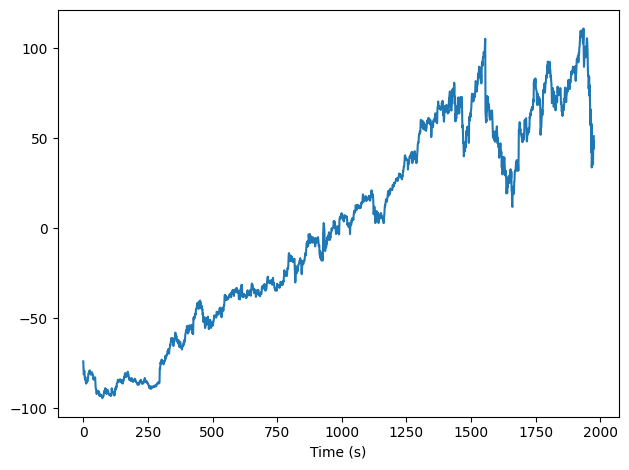

In [5]:
import pandas as pd
from thinkdsp import Wave

df = pd.read_csv('csv/FB_2.csv', header=0, parse_dates=[0])
ys = df['Close']

if len(ys) % 2:
    ys = ys[:-1]

in_wave = Wave(ys, framerate=1)
in_wave.unbias()
in_wave.plot()
decorate(xlabel='Time (s)')

Получим спектр до нарастающей суммы:

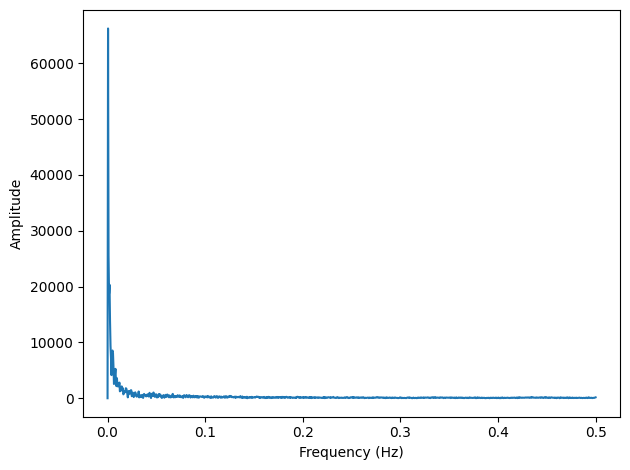

In [6]:
in_spectrum = in_wave.make_spectrum()
in_spectrum.plot()
decorate(xlabel='Frequency (Hz)', ylabel='Amplitude')

Выведем нарастающую сумму:

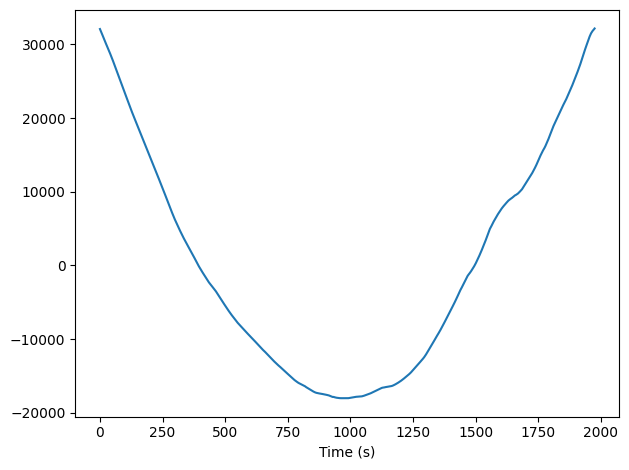

In [7]:
out_wave = in_wave.cumsum()
out_wave.unbias()
out_wave.plot()
decorate(xlabel='Time (s)')

Её спектр:

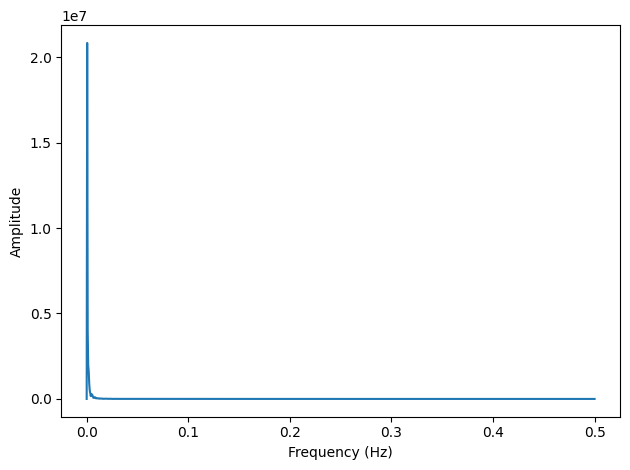

In [8]:
out_spectrum = out_wave.make_spectrum()
out_spectrum.plot()
decorate(xlabel='Frequency (Hz)', ylabel='Amplitude')

Отношение выхода ко входу:

In [9]:
sum(in_spectrum.amps < 1), len(in_spectrum)

(np.int64(1), 989)

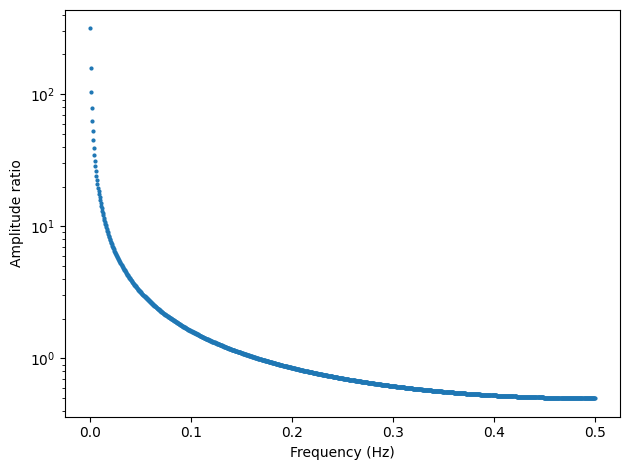

In [10]:
ratio_spectrum = out_spectrum.ratio(in_spectrum, thresh=1)
ratio_spectrum.plot(marker='.', ms=4, ls='')

decorate(xlabel='Frequency (Hz)',
         ylabel='Amplitude ratio',
         yscale='log')

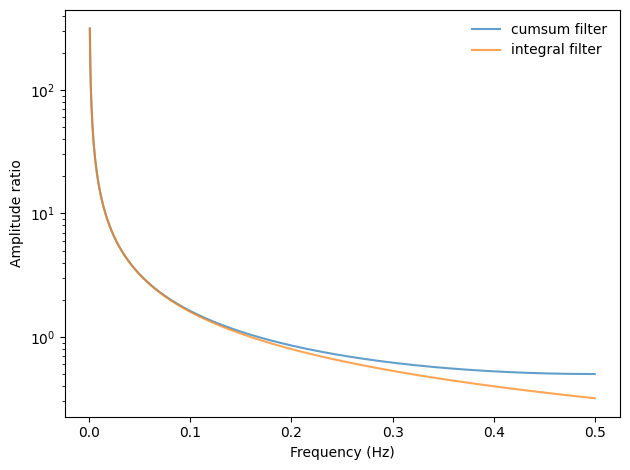

In [11]:
from thinkdsp import zero_pad, PI2

# compute the diff filter
diff_window = np.array([1.0, -1.0])
padded = zero_pad(diff_window, len(in_wave))
diff_wave = Wave(padded, framerate=in_wave.framerate)
diff_filter = diff_wave.make_spectrum()

# compute the cumsum filter by inverting the diff filter
cumsum_filter = diff_filter.copy()
cumsum_filter.hs[1:] = 1 / cumsum_filter.hs[1:]
cumsum_filter.hs[0] = np.inf

# compute the integration filter
integ_filter = cumsum_filter.copy()
integ_filter.hs[1:] = integ_filter.framerate / (PI2 * 1j * integ_filter.fs[1:])
integ_filter.hs[0] = np.inf

cumsum_filter.plot(label='cumsum filter', alpha=0.7)
integ_filter.plot(label='integral filter', alpha=0.7)

decorate(xlabel='Frequency (Hz)',
         ylabel='Amplitude ratio',
         yscale='log')



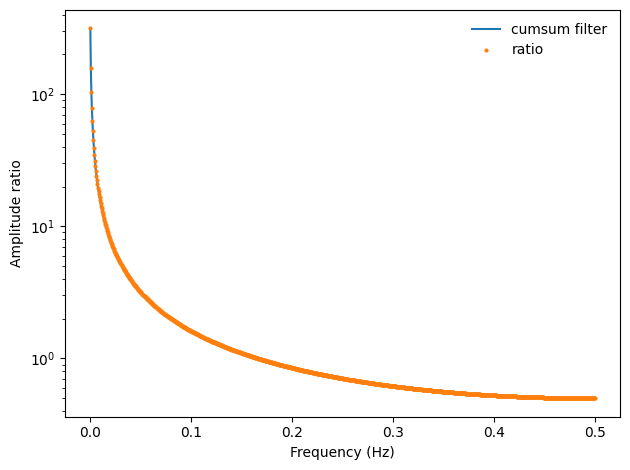

In [12]:
cumsum_filter.plot(label='cumsum filter')
ratio_spectrum.plot(label='ratio', marker='.', ms=4, ls='')
decorate(xlabel='Frequency (Hz)',
         ylabel='Amplitude ratio',
         yscale='log')

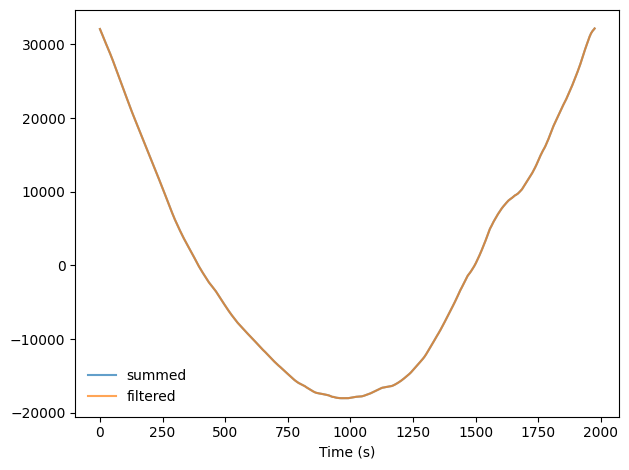

In [13]:
out_wave.plot(label='summed', alpha=0.7)

cumsum_filter.hs[0] = 0
out_wave2 = (in_spectrum * cumsum_filter).make_wave()
out_wave2.plot(label='filtered', alpha=0.7)

decorate(xlabel='Time (s)')

## Упражнение 9.2

Создадим треугольный сигнал:

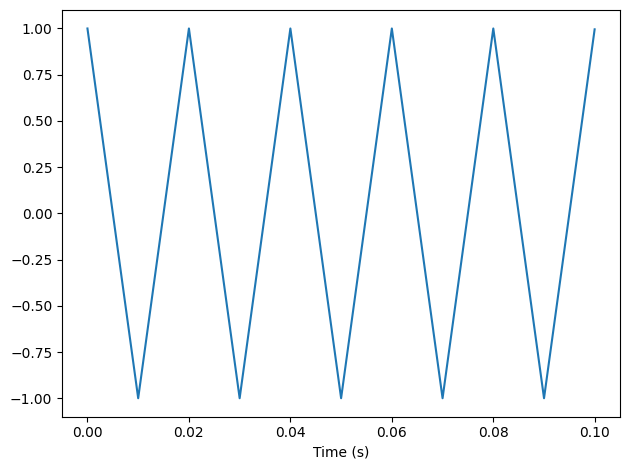

In [14]:
from thinkdsp import TriangleSignal

in_wave = TriangleSignal(freq=50).make_wave(duration=0.1, framerate=44100)
in_wave.plot()
decorate(xlabel='Time (s)')

Применим `diff` к сигналу и выведем результат:

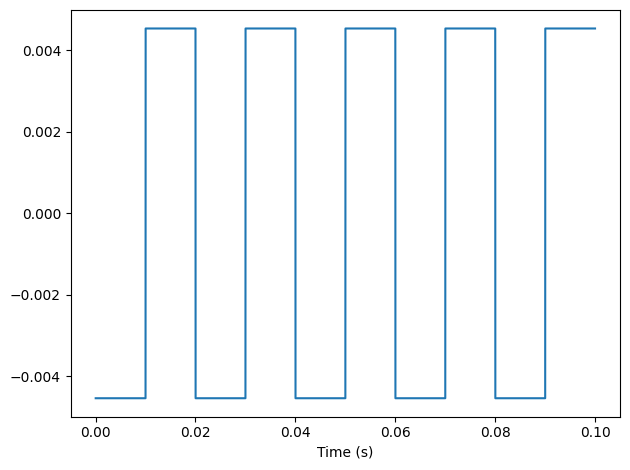

In [15]:
out_wave = in_wave.diff()
out_wave.plot()
decorate(xlabel='Time (s)')

Продифференцируем спектр сигнала, преобразуем его обратно в сигнал и выведем:

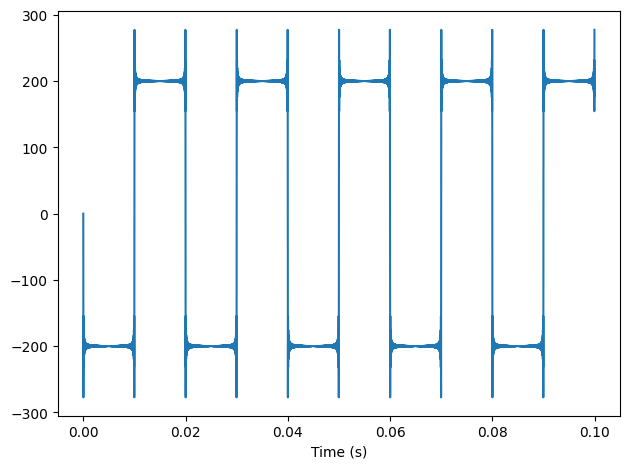

In [16]:
out_wave2 = in_wave.make_spectrum().differentiate().make_wave()
out_wave2.plot()
decorate(xlabel='Time (s)')

Заметим, что структура сигнала нарушена. Это связано с тем, что функция содержит точки, где производной не существует.

## Упражнение 9.3

Создадим прямоугольный сигнал:

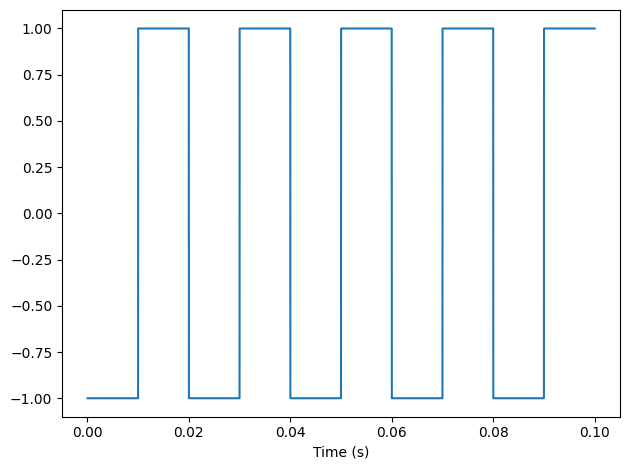

In [17]:
from thinkdsp import SquareSignal

in_wave = SquareSignal(freq=50).make_wave(duration=0.1, framerate=44100)
in_wave.plot()
decorate(xlabel='Time (s)')

Применим `cumsum`:

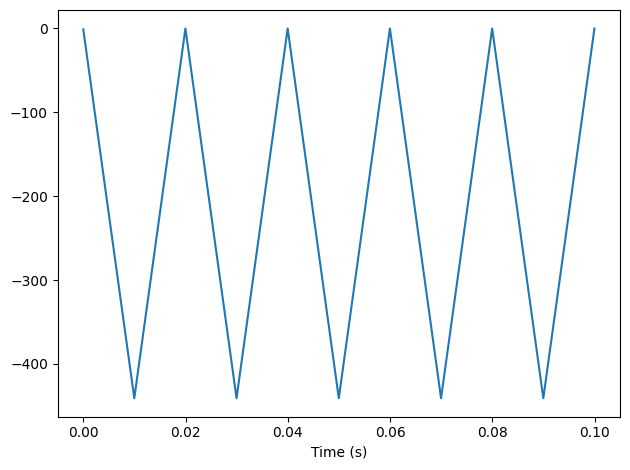

In [18]:
out_wave = in_wave.cumsum()
out_wave.plot()
decorate(xlabel='Time (s)')

Проинтегрируем прямоугольный сигнал. На выходе тоже будет треугольный сигнал, но с другой амплитудой:

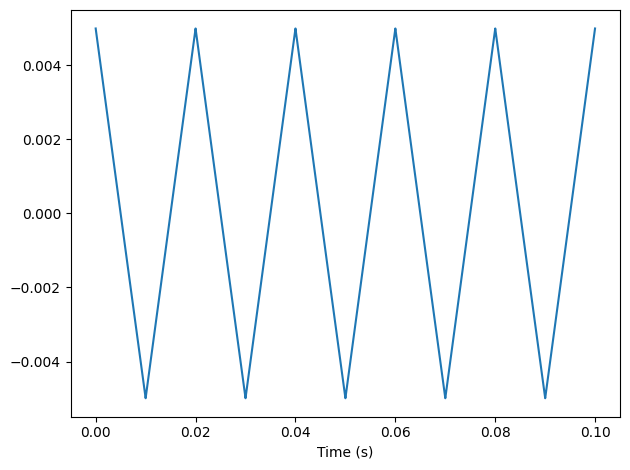

In [19]:
spectrum = in_wave.make_spectrum().integrate()
spectrum.hs[0] = 0
out_wave2 = spectrum.make_wave()
out_wave2.plot()
decorate(xlabel='Time (s)')

Если применить к сигналам `unbias()` и `normalize()`, они получатся почти идентичными.

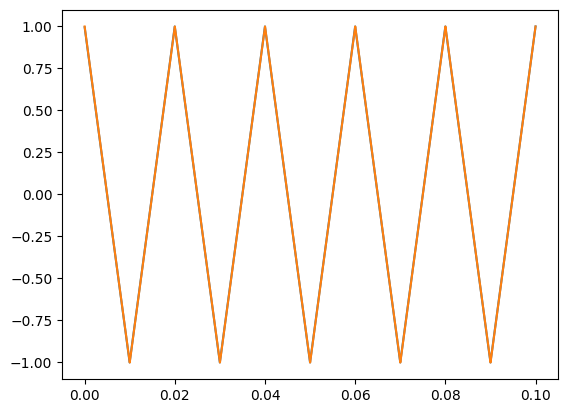

In [21]:
out_wave.unbias()
out_wave.normalize()
out_wave2.normalize()
out_wave.plot()
out_wave2.plot()

## Упражнение 9.4

Рассмотрим двойное интегрирование. Для этого создадим пилообразный сигнал:

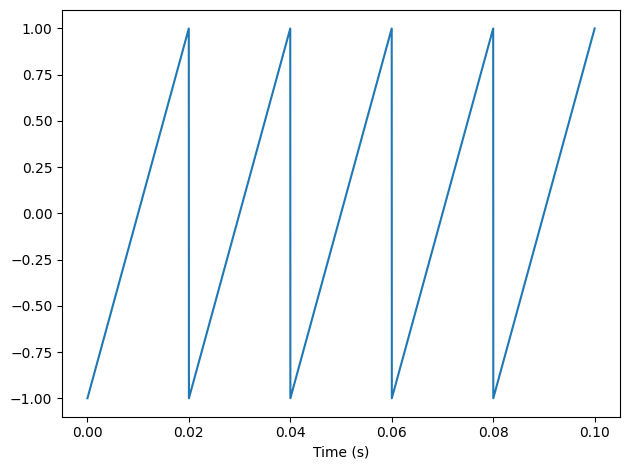

In [22]:
from thinkdsp import SawtoothSignal

in_wave = SawtoothSignal(freq=50).make_wave(duration=0.1, framerate=44100)
in_wave.plot()
decorate(xlabel='Time (s)')

Вычислим его спектр, применим `integrate()` дважды, а затем выведем результирующий сигнал и его спектр.

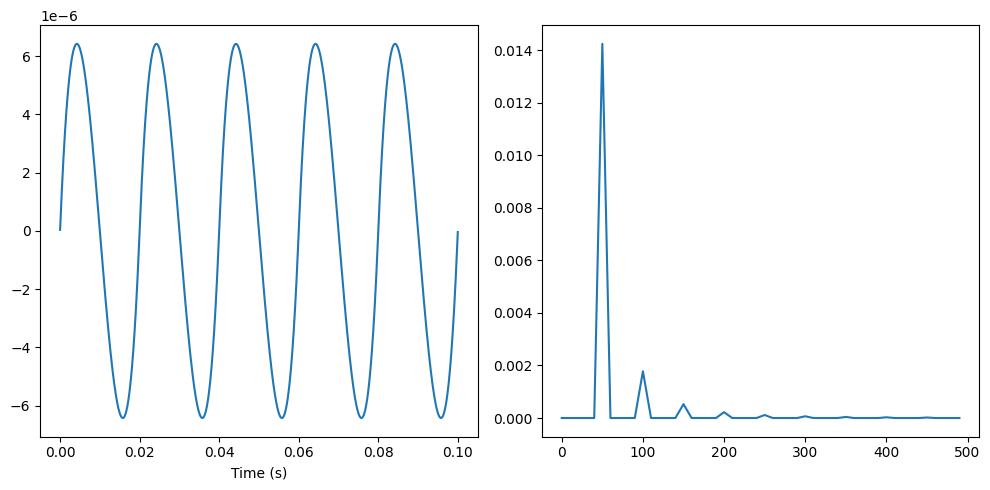

In [27]:
spectrum = in_wave.make_spectrum().integrate().integrate()
spectrum.hs[0] = 0
out_wave2 = spectrum.make_wave()
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
out_wave2.plot()
decorate(xlabel='Time (s)')
plt.subplot(1, 2, 2)
out_wave2.make_spectrum().plot(high=500)
plt.tight_layout()

Сигнал стал очень напоминать синусоиду. Это связано с тем, что интегрирование выступает в роли фильтра НЧ и от сигнала постепенно остается только одна гармоника.

## Упражнение 9.5

Рассмотрим влияние второй разности и второй производной. Для этого создадим `CubicSignal`:

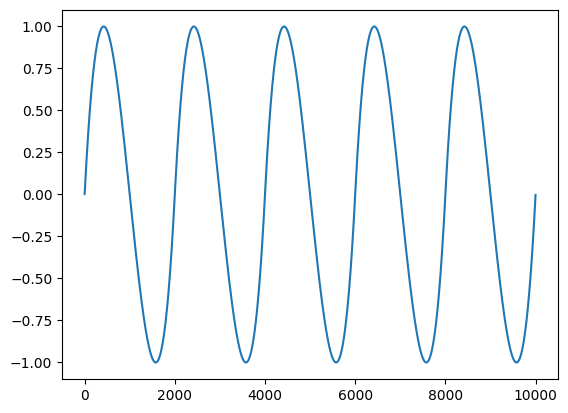

In [28]:
from thinkdsp import CubicSignal

in_wave = CubicSignal(freq=0.0005).make_wave(duration=10000, framerate=1)
in_wave.plot()

Продифференцируем один раз. Получим параболический сигнал.

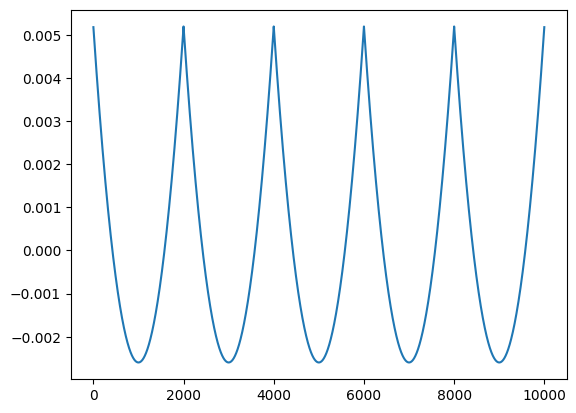

In [30]:
out_wave = in_wave.diff()
out_wave.plot()

Продифференцируем второй раз. Получим пилообразный сигнал.

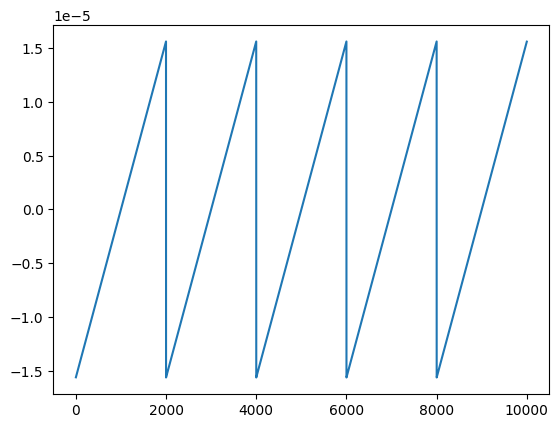

In [31]:
out_wave = out_wave.diff()
out_wave.plot()

Вычислим вторую производную, применив `differentiate()` к спектру:

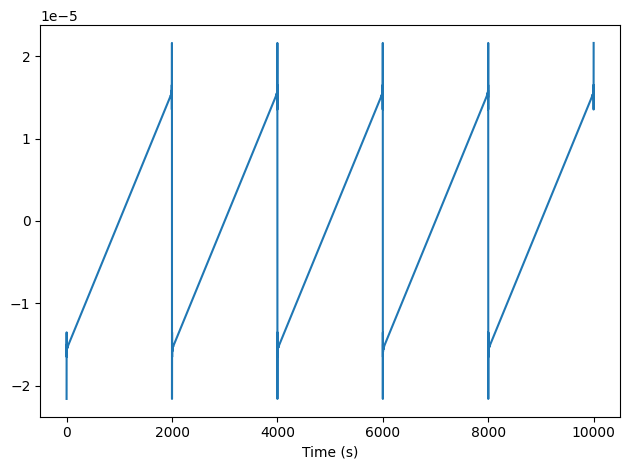

In [33]:
spectrum = in_wave.make_spectrum().differentiate().differentiate()
out_wave2 = spectrum.make_wave()
out_wave2.plot()
decorate(xlabel='Time (s)')

Снова получили пилообразный сигнал, однако искаженный из-за недифференцируемости функции в вершинах углов.